# Transferring Image Styles

This notebook provides you with a complete code example that loads the content image, the style image, and the VGG16 pre-trained neural network, and uses them to transfer the style to the image.

## Loading the Content and Style Images

Load a crop of the content image ...

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [1]:
from PIL import Image

content = (
    Image.open("neuraltissue_with_colorlabels.png")
    .convert("RGB")
    .crop((100, 170, 100 + 256, 170 + 256)) 
)

... plot it ...

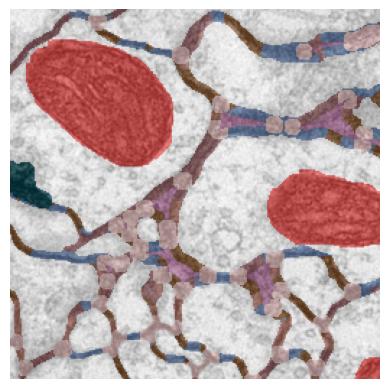

In [2]:
import matplotlib.pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.savefig("fig_03_D1a.pdf", bbox_inches='tight')  ### plt.show()

... load the style image ...

You'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona).

In [3]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

... and plot it.

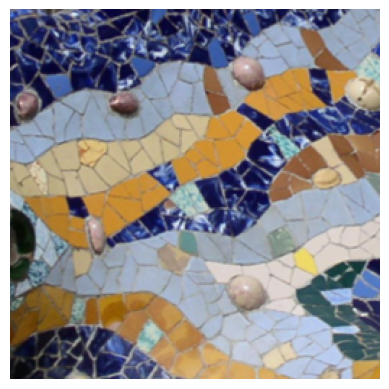

In [4]:
plt.imshow(style)
plt.axis("off")
plt.savefig("fig_03_D1b.pdf", bbox_inches='tight')  ### plt.show()

## Loading a Pre-Trained Neural Network

In [5]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

low = torch.tensor((- mean / std).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

## Implementing Style Transfer

Implement a function to calculate the Gram matrix between all the activations of a specific layer ...

In [7]:
from torch import bmm

def gram(tensor):
    """Gram matrix."""
    batch_size, num_channels, height, width = tensor.size()
    features = tensor.view(batch_size, num_channels, height * width)
    gram_matrix = bmm(features, features.transpose(1, 2)) / (height * width)
    return gram_matrix

... define functions to to convert an image to a tensor, and vice versa ...

In [8]:
import torchvision.transforms as tt

def image_to_tensor(im, mean, std):
    """Convert image to tensor."""
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)]) 
    return normalize(im).unsqueeze(0).requires_grad_(True)

def tensor_to_image(image, mean, std):
    """Convert tensor to image."""
    denormalize = tt.Normalize(mean=- mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy() 
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255)
    im_array = im_array.astype(np.uint8)
    return Image.fromarray(im_array, "RGB")

... define a context manager class ...

In [9]:
class Fwd_Hooks():
    """Forward hook."""
    
    def __init__(self, layers):
        """Initialize forward hooks."""
        self.hooks = []
        self.activations_list = []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))
    
    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations_list.append(output)

    def __enter__(self, *args):
        """Enter context and register hooks."""
        return self

    def __exit__(self, *args):
        """Exit context management and remove hooks."""
        for hook in self.hooks:
            hook.remove()

... and define a function to implement style transfer.

In [10]:
def style_transfer(image, content, style, content_layers, style_layers,
                   lr=1, iter_num=100, beta=1e3, fignum=2):  ### lr=1, iter_num=100, beta=1e3):
    """Perform style transfer."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    
    image_tensor = image_to_tensor(image, mean, std)
    
    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach()
                           for activations in fh.activations_list]
    
    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach())
                    for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr) 
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        """Closure function for the optimizer.""" 
        optimizer.zero_grad()
        
        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list
        
        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss += mse_loss(ia, ca) / n_f ** 2
        content_loss /= len(image_content_activations)
        
        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss += mse_loss(gi, gt) / n_g ** 2
        style_loss /= len(gram_image) 
        
        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()        
        return total_loss
    
    for i in range(iter_num):
        print(f"iteration {i}")
        optimizer.step(closure)
        
        image = tensor_to_image(image_tensor, mean, std)

        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            ### plt.show()
            if i == 0:
                plt.savefig(f"fig_03_D{fignum}a.pdf", bbox_inches='tight')
            elif i == 5:
                plt.savefig(f"fig_03_D{fignum}b.pdf", bbox_inches='tight')
            elif i == 10:
                plt.savefig(f"fig_03_D{fignum}c.pdf", bbox_inches='tight')
            elif i == 49:
                plt.savefig(f"fig_03_D{fignum}d.pdf", bbox_inches='tight')
    
    return image

## Transferring the Style of an Image to Another Image

Starting from a random image ...

iteration 0
content_loss=328.54638671875 style_loss=221.9719696044922
content_loss=328.5445251464844 style_loss=221.9576416015625
content_loss=298.870849609375 style_loss=68.37837219238281
content_loss=286.8116149902344 style_loss=41.968772888183594
content_loss=272.77496337890625 style_loss=19.85501480102539
content_loss=266.5243225097656 style_loss=10.554694175720215
content_loss=268.01116943359375 style_loss=6.0257134437561035
content_loss=284.1927490234375 style_loss=3.7482573986053467
content_loss=324.64434814453125 style_loss=2.3627467155456543
content_loss=352.1361389160156 style_loss=1.6672999858856201
content_loss=349.65631103515625 style_loss=1.2637211084365845
content_loss=364.2626953125 style_loss=0.9979780316352844
content_loss=342.52325439453125 style_loss=0.876913845539093
content_loss=348.2043151855469 style_loss=0.7400725483894348
content_loss=350.2236633300781 style_loss=0.6430418491363525
content_loss=341.0850830078125 style_loss=0.5729366540908813
content_loss=345.2

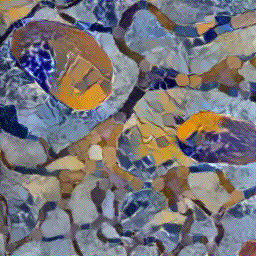

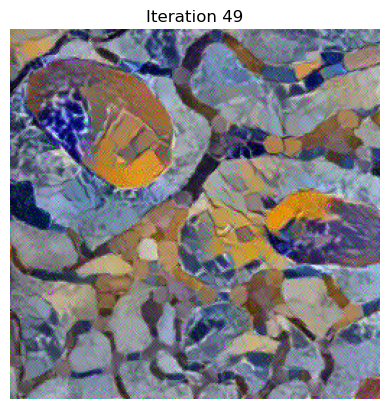

In [11]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=image_in,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e3,
    fignum=2,  ###
)

... and using the content image as a starting point.

iteration 0
content_loss=0.0 style_loss=1.904022216796875
content_loss=2.2320807602227433e-06 style_loss=1.903765082359314
content_loss=51.435279846191406 style_loss=1.2634533643722534
content_loss=72.23223114013672 style_loss=0.875190258026123
content_loss=98.23179626464844 style_loss=0.6622881889343262
content_loss=103.97579193115234 style_loss=0.5329758524894714
content_loss=116.95336151123047 style_loss=0.42369309067726135
content_loss=140.140380859375 style_loss=0.3533737063407898
content_loss=134.3835906982422 style_loss=0.32554107904434204
content_loss=137.84530639648438 style_loss=0.29211777448654175
content_loss=144.33697509765625 style_loss=0.2580941319465637
content_loss=150.04290771484375 style_loss=0.2289465367794037
content_loss=163.8482666015625 style_loss=0.20378677546977997
content_loss=163.205810546875 style_loss=0.19055308401584625
content_loss=167.43052673339844 style_loss=0.17652687430381775
content_loss=170.26300048828125 style_loss=0.16321392357349396
content_los

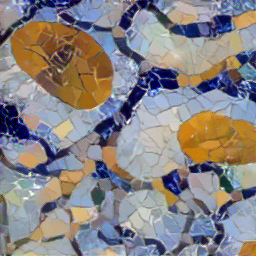

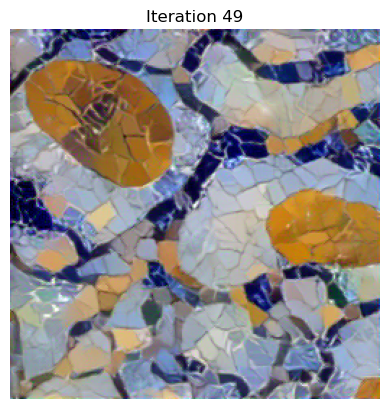

In [12]:
imarray = np.random.rand(256, 256, 3) * 255
image_in = Image.fromarray(imarray.astype("uint8")).convert("RGB")

style_transfer(
    image=content,
    content=content,
    style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1,
    iter_num=50,
    beta=1e5,
    fignum=3,  ###
)